In [20]:
import numpy as np
import time
from glob import glob
from natsort import natsorted
from skimage.measure import label
from skimage.segmentation import relabel_sequential
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from metrics import evaluate 
from utils import *
import cv2, os
import skimage.io as io

In [21]:
meds = ["graphcl", "wsh", "cncpt"]
len_test = 40

In [22]:

graphcl_path = natsorted (glob ('/home/tuan/GraphCL3D/deploy/zebrafish3D/test/*.tif')) [:len_test]
unet_wsh_path = natsorted (glob ('/home/tuan/CNN3D/deploy/96_zebrafish3D/wsh*.tif')) [:len_test]
unet_thr_path = natsorted (glob ('/home/tuan/CNN3D/deploy/96_zebrafish3D/thres*.tif')) [:len_test]
unet_cncpt_path = natsorted (glob ('/home/tuan/CNN3D/deploy/96_zebrafish3D/labeled*.tif')) [:len_test]
gt_path = natsorted (glob ('/home/tuan/GraphCL3D/Data/Zebrafish3D/3D_96/test/B/*.tif'))
em_path = natsorted (glob ('/home/tuan/GraphCL3D/Data/Zebrafish3D/3D_96/test/A/*.tif'))


In [23]:
def watershed_full (image, min_dist=12):
    image = image [::-1]
    distance = ndi.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, min_distance=min_dist, labels=image, exclude_border=False)
    markers = ndi.label(local_maxi)[0]
    watershed_lbl = watershed(-distance, markers, mask=image).astype (np.int32)
    return watershed_lbl [::-1]

In [24]:

graphcl = [io.imread (pth) for pth in graphcl_path]
unet_wsh = [io.imread (pth) for pth in unet_wsh_path]
unet_thr = [io.imread (pth) for pth in unet_thr_path]
unet_cncpt = [io.imread (pth) for pth in unet_cncpt_path]
em =  [io.imread (pth) for pth in em_path]
gt = [io.imread (pth) for pth in gt_path]

In [25]:
unet_wsh = [watershed_full (img, 10) for img in unet_thr]

In [26]:
gt_median_sizes = [np.median(np.unique (img, return_counts=True)[1]) for img in gt]
max_ids = np.max ([len (np.unique (img)) for img in gt])
print (gt_median_sizes)
print ("max id: ", max_ids)
print ("Mean ", np.min (gt_median_sizes))

[3073.0, 4187.0, 3905.0, 3655.5, 3816.0, 4147.5, 4090.5, 3396.5, 2786.0, 2981.0, 4068.0, 4274.0, 3871.0, 3116.0, 4482.0, 4095.0, 2823.0, 3521.5, 3556.5, 3430.0, 4186.0, 4818.5, 3106.5, 3247.0, 3097.0, 3527.0, 3321.0, 1263.0, 2656.0, 3791.0, 2962.0, 5155.0, 3003.5, 3540.5, 2741.5, 2869.0, 2802.0, 3684.0, 4385.5, 4098.0]
max id:  147
Mean  1263.0


In [27]:
#Post-processing GraphCL
metrics = ["bestDice", "rand_i", "voi_split", "voi_merge", "adapted_rand", "AJI"]
minsize = 300
scores = np.zeros (len (metrics))

post_processed = []
post_proc_time = 0

for i in range (len_test):
    curtime = time.time ()
    pred_lbl = label (graphcl [i])
    gt_lbl = gt [i]
    pred_lbl = relabel_sequential (clean (pred_lbl, minsize)) [0]
    post_processed += [pred_lbl]
    post_proc_time += time.time () - curtime
    
#     size = gt_lbl.shape
#     pred_lbl = cv2.resize (pred_lbl.astype (np.int32), size, interpolation=cv2.INTER_NEAREST)
    
    scores += np.array (evaluate (pred_lbl, gt_lbl))

avg_post_proc_time = post_proc_time / len_test
scores /= len_test
    
for met, score in zip (metrics, scores):
    print (met, ":\t", score)
print ("Post processing time: ", avg_post_proc_time)

bestDice :	 0.9016134716981211
rand_i :	 0.9397763679602933
voi_split :	 0.14481611442022096
voi_merge :	 0.15445786634569364
adapted_rand :	 0.0381026122012143
AJI :	 0.8857675878846376
Post processing time:  0.062420839071273805


In [17]:
graphcl = post_processed

In [28]:
metrics = ["bestDice", "rand_i", "voi_split", "voi_merge", "adapted_rand", "AJI"]
tmp = []
res = [graphcl, unet_wsh, unet_cncpt]
for med, met, lbl_lists in zip (meds, metrics, res):
    if med == 'graphcl':
        continue
    scores = np.zeros (len (metrics))
    for i in range (len_test):
        gt_lbl = gt [i]
        pred_lbl = lbl_lists [i]
        scores += np.array (evaluate (pred_lbl, gt_lbl))
        lbl_lists [i] = pred_lbl
    tmp += [lbl_lists]
    scores /= len_test
    print (med)
    for met, score in zip (metrics, scores):
        print (met, ":\t", score)
    print ('-' * 60)
unet_wsh, unet_cncpt = tmp

wsh
bestDice :	 0.8545648575635569
rand_i :	 0.9135758372143898
voi_split :	 0.23799509754839027
voi_merge :	 0.24876239414798645
adapted_rand :	 0.05486570814553552
AJI :	 0.8428964568060158
------------------------------------------------------------
cncpt
bestDice :	 0.5249058891622943
rand_i :	 0.8788281295713002
voi_split :	 0.11177430268426489
voi_merge :	 1.5634767756987995
adapted_rand :	 0.5609119892927074
AJI :	 0.2773081139483329
------------------------------------------------------------


0


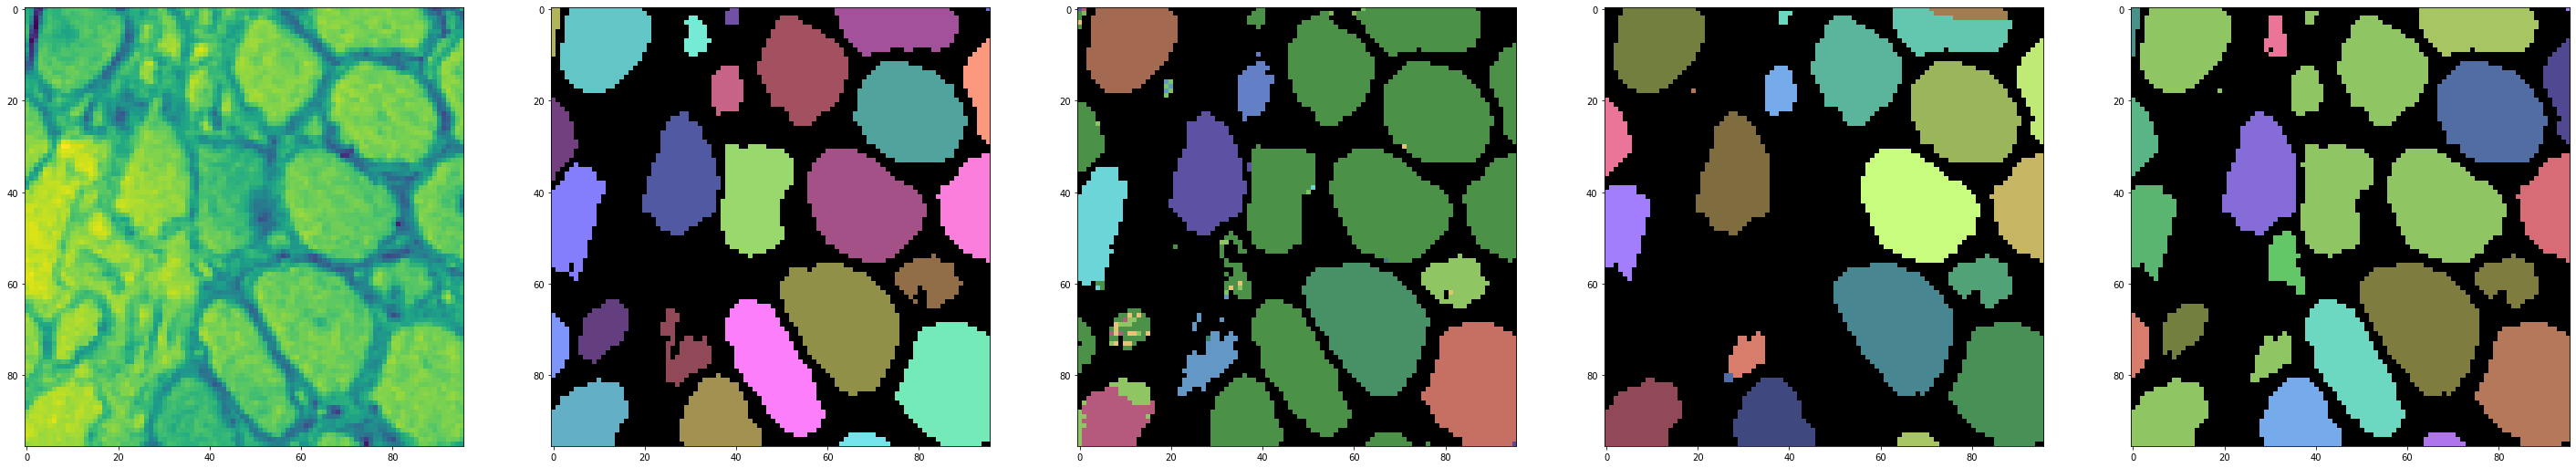

1


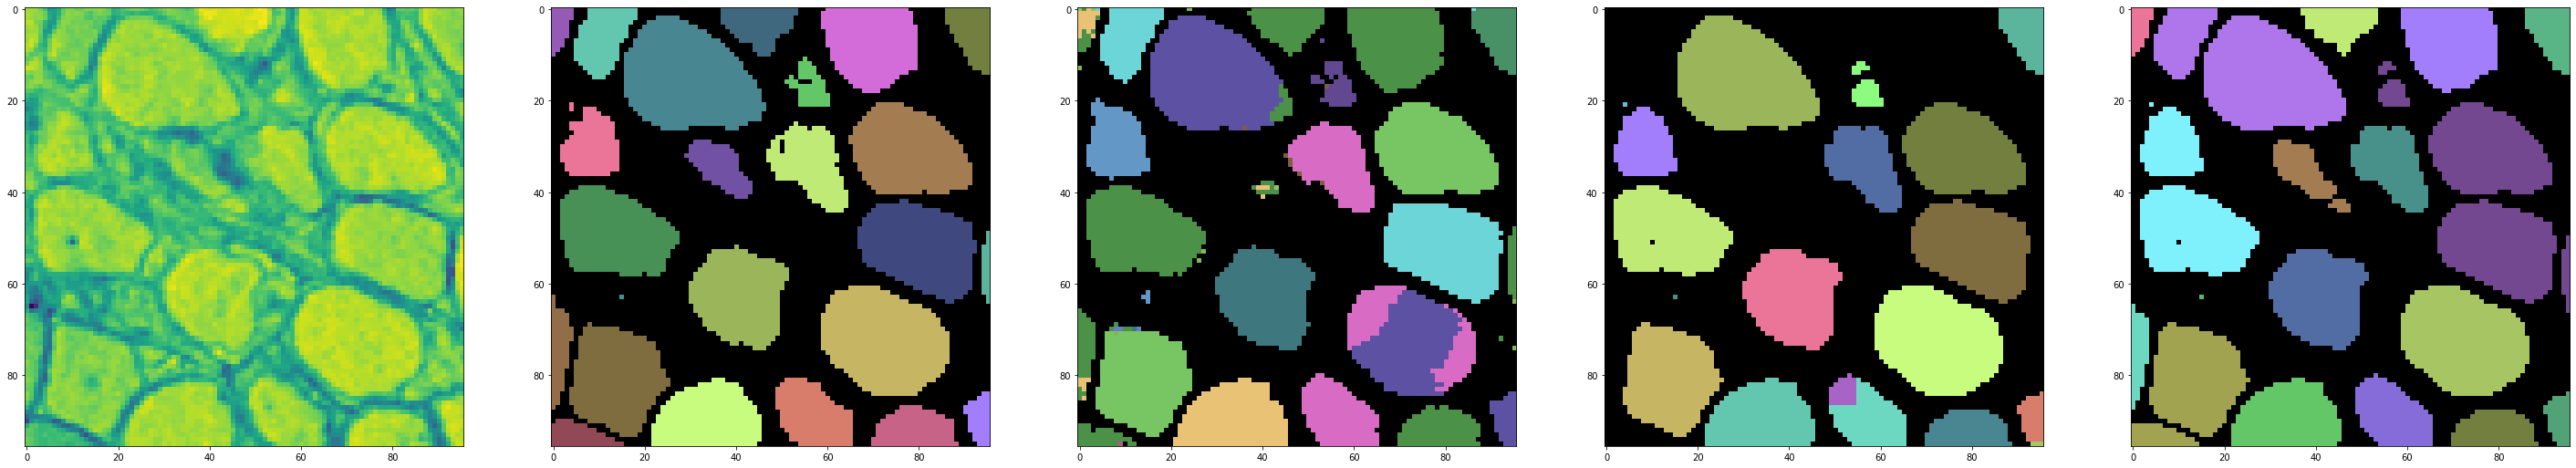

2


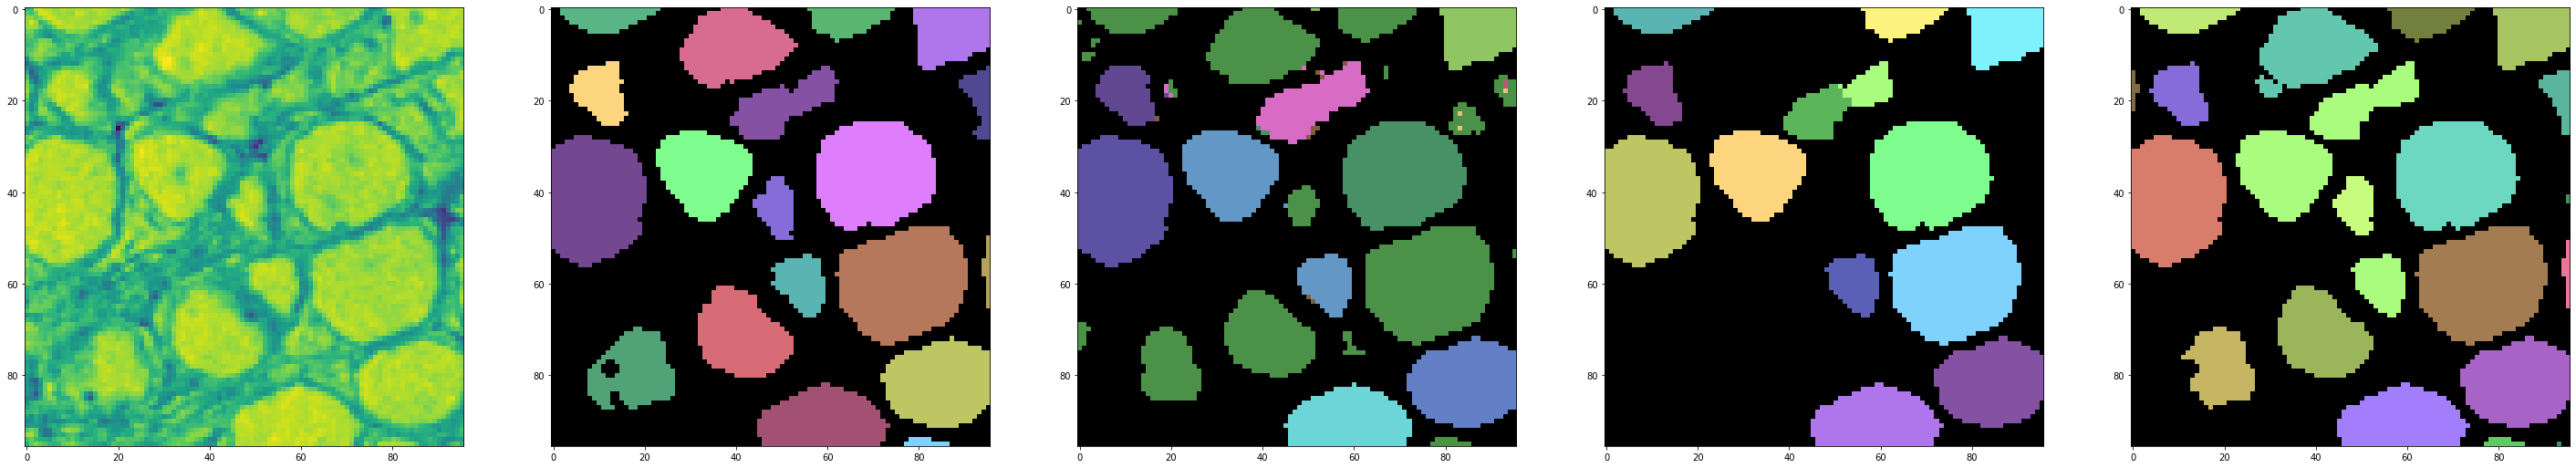

3


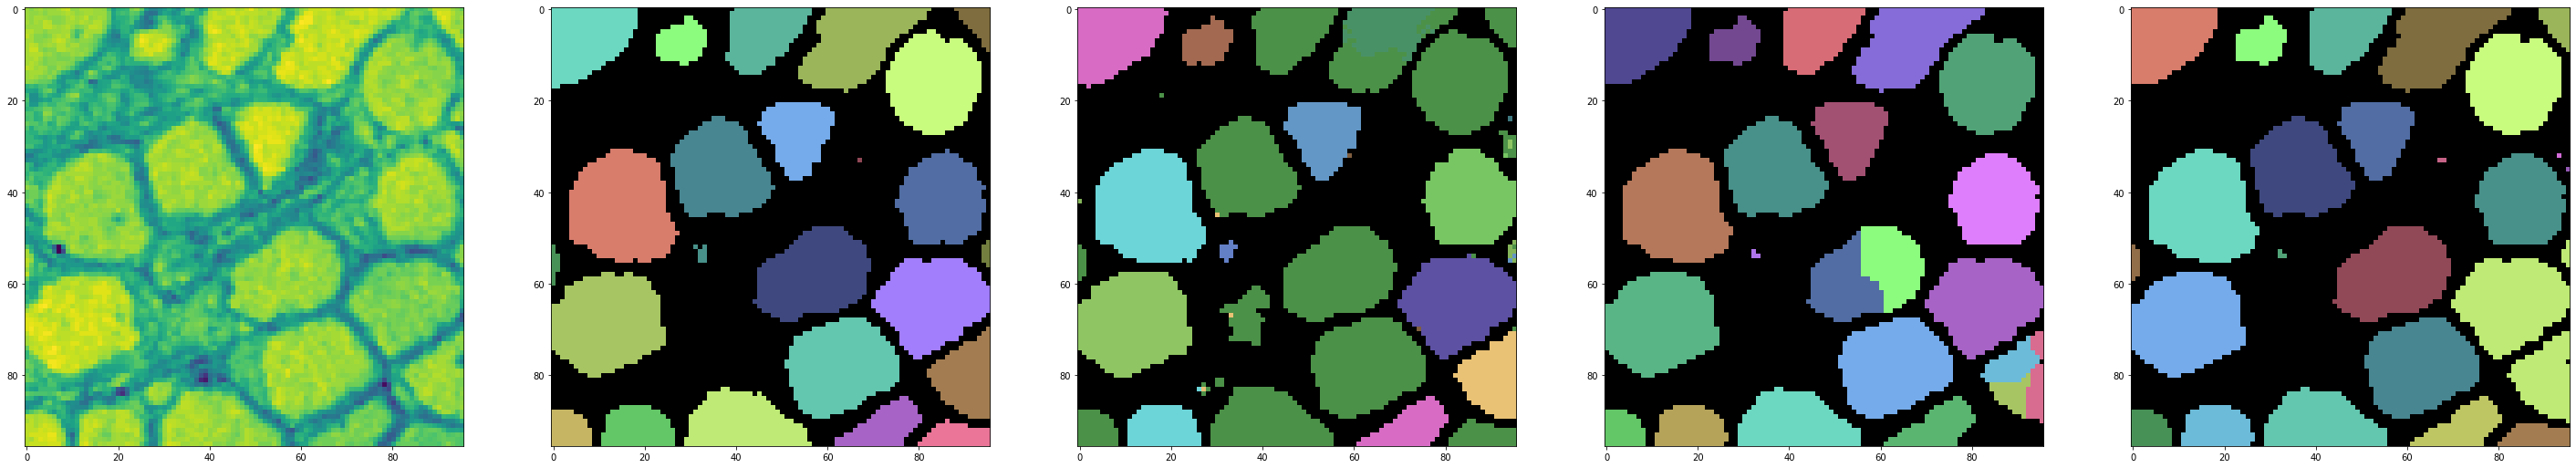

4


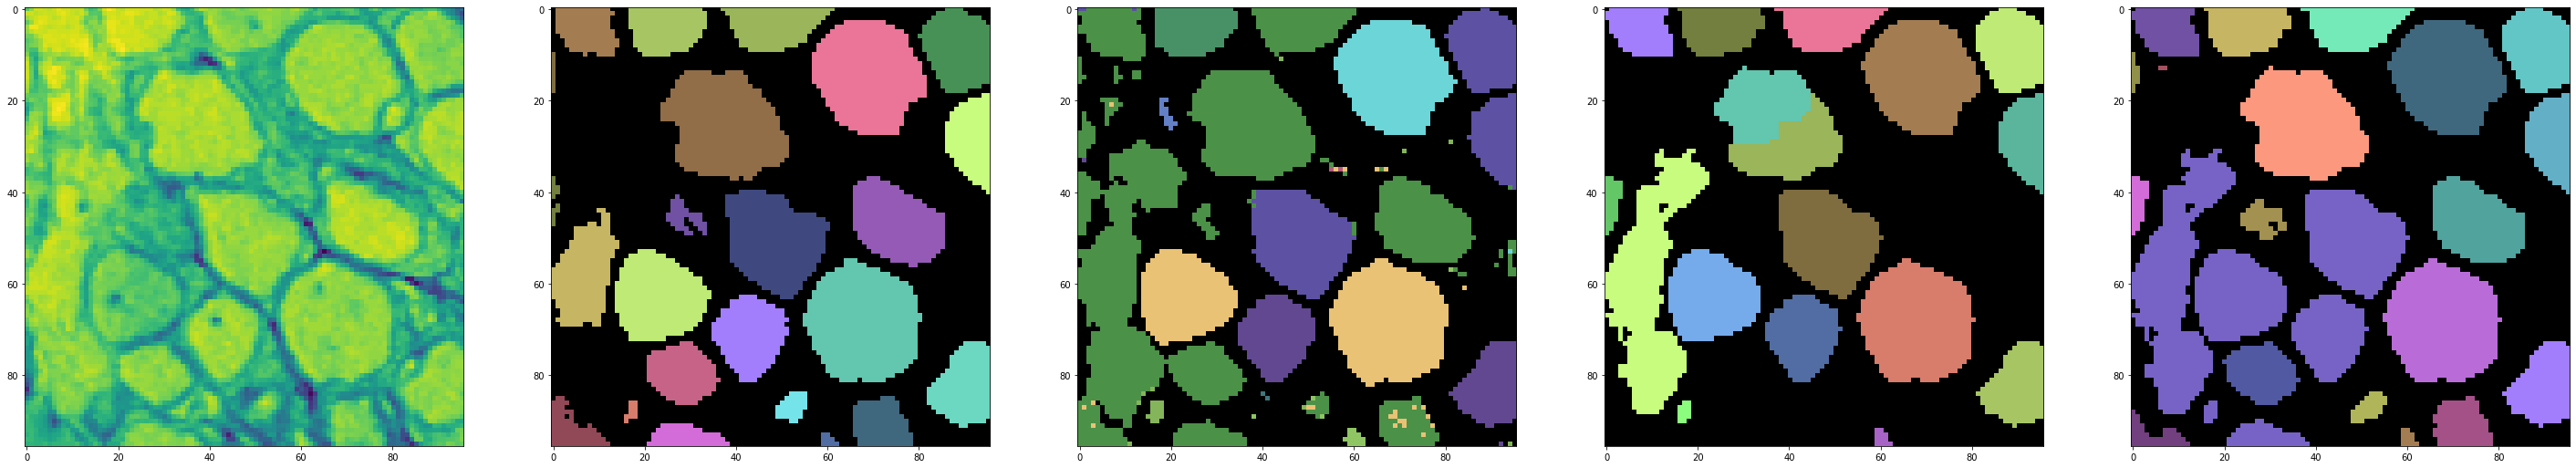

5


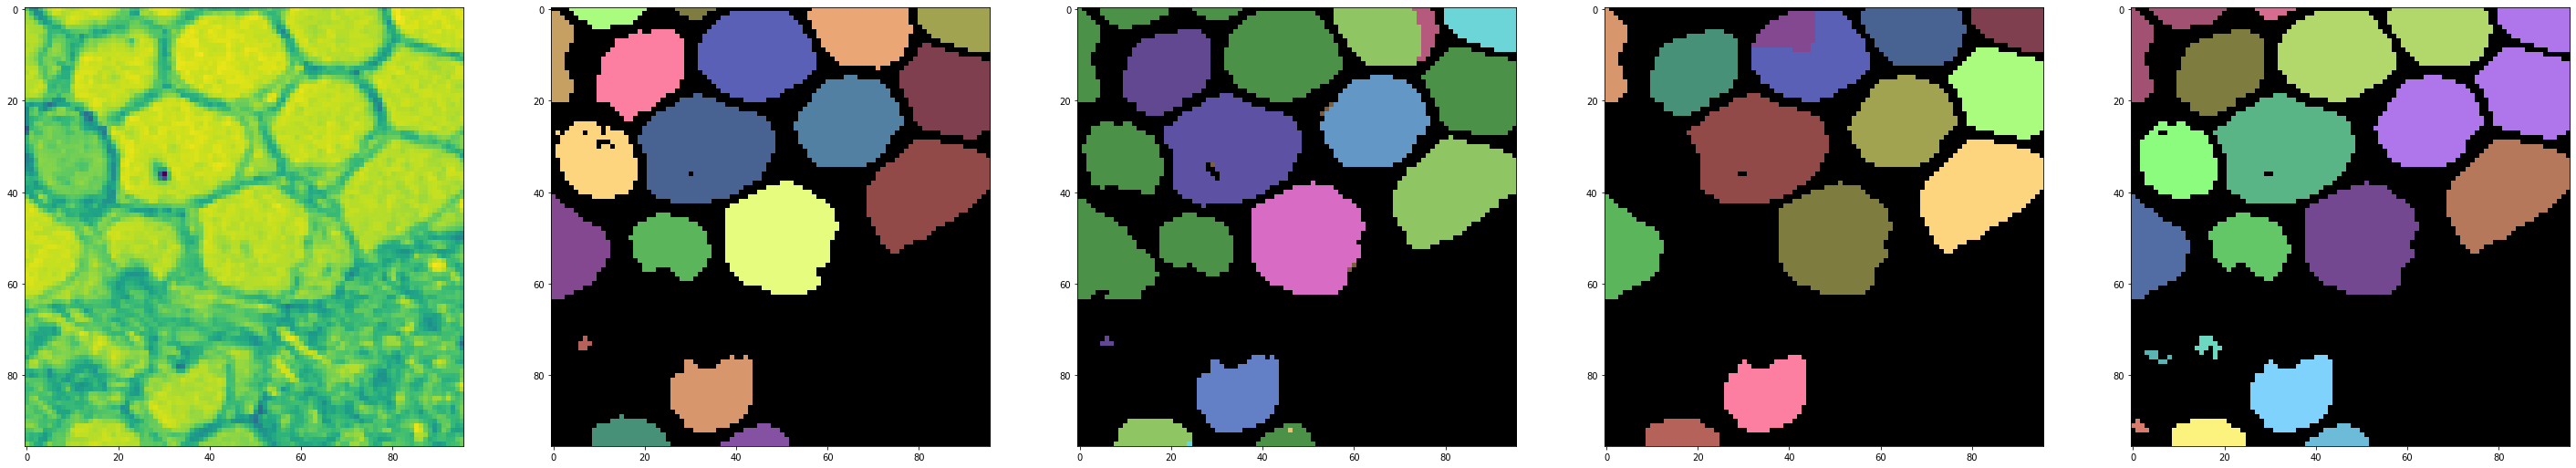

6


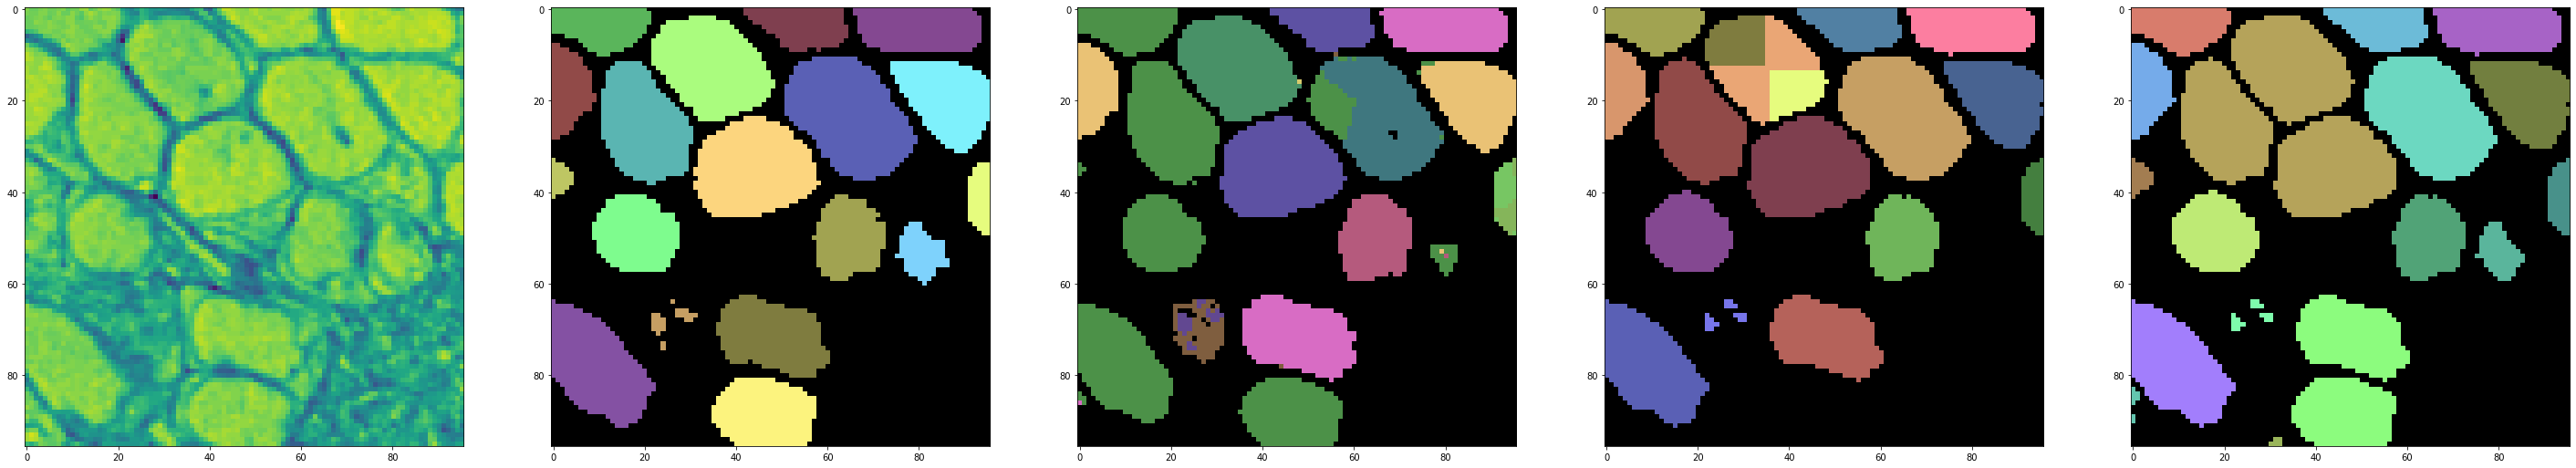

7


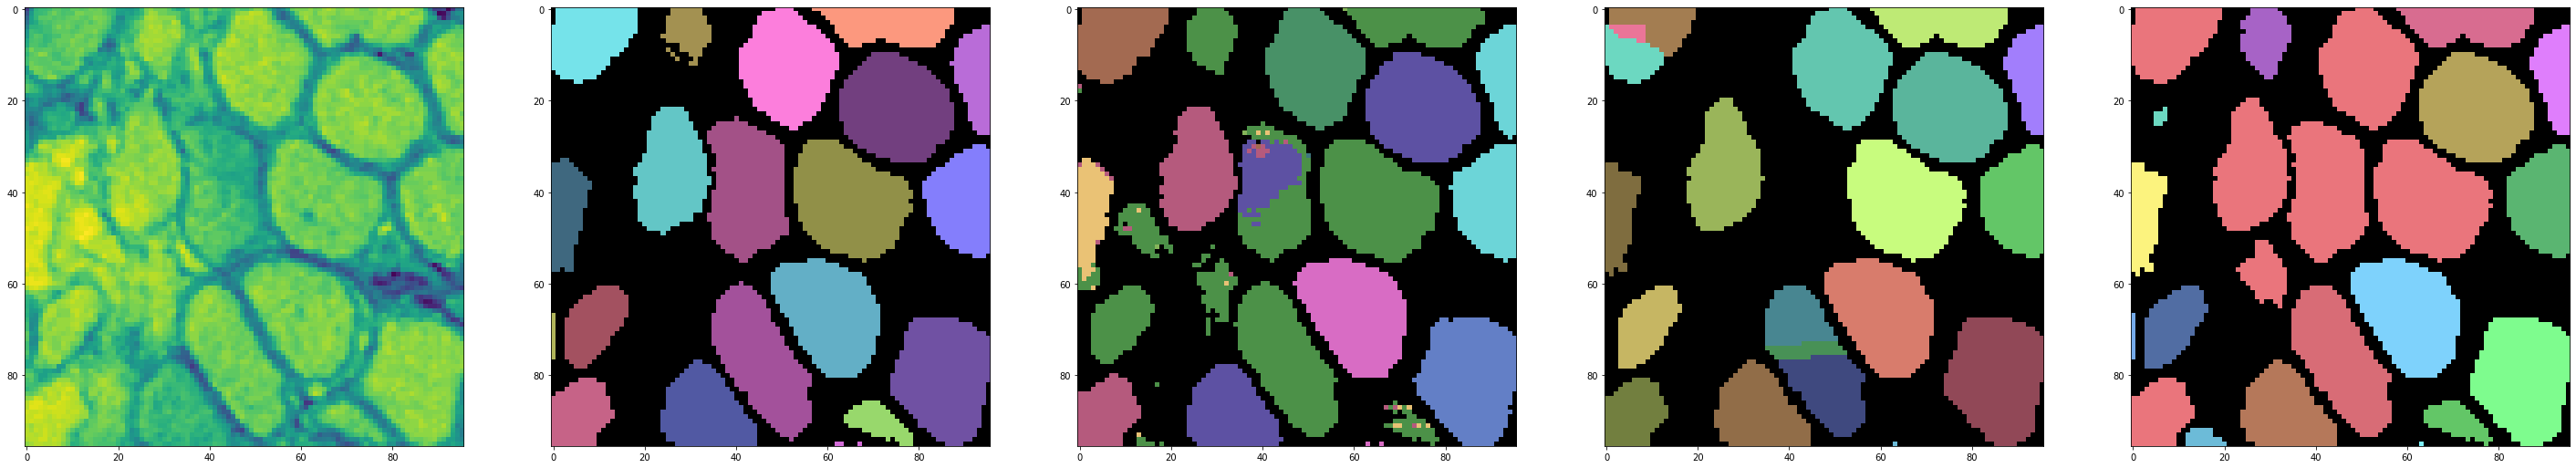

8


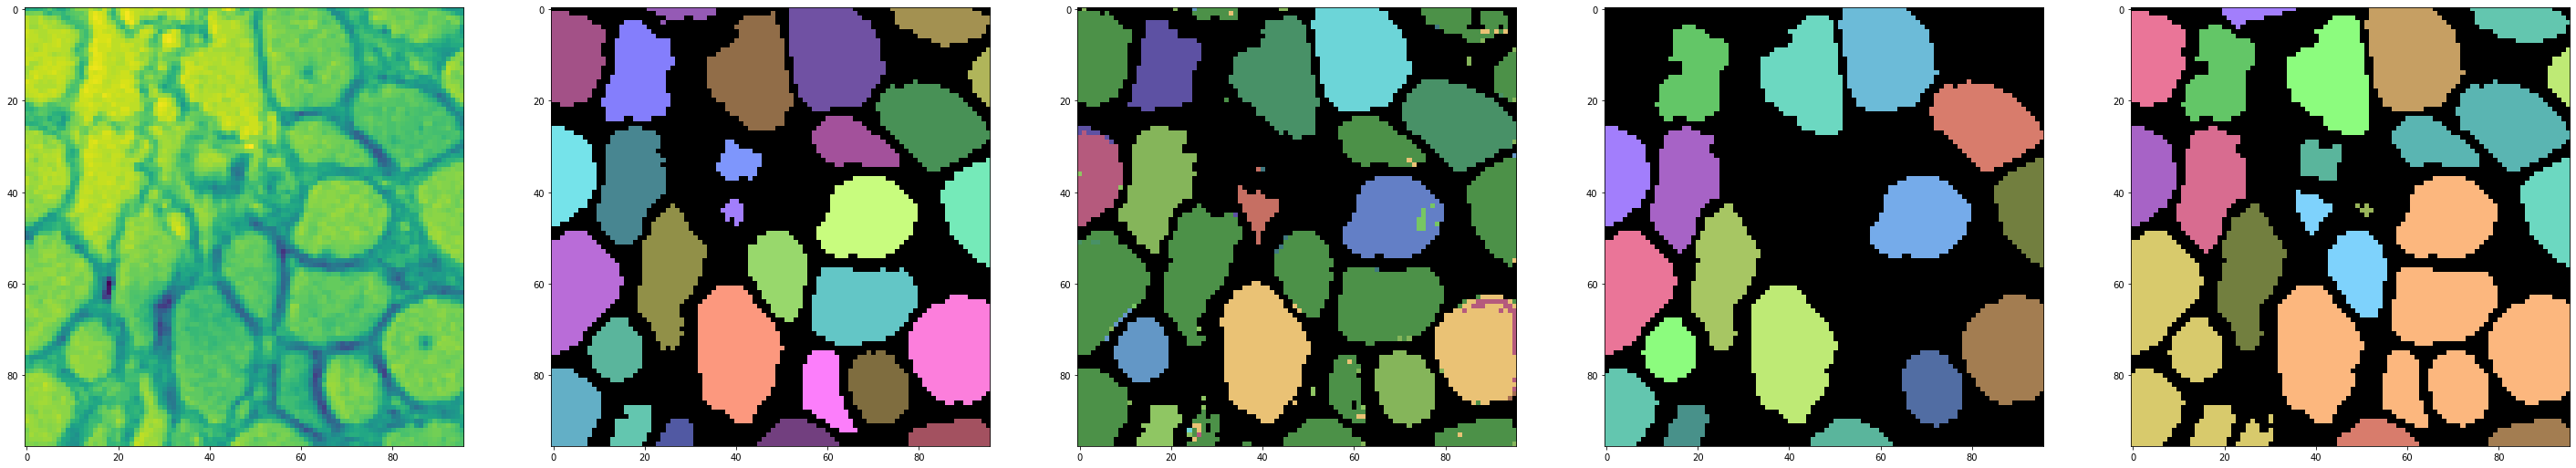

9


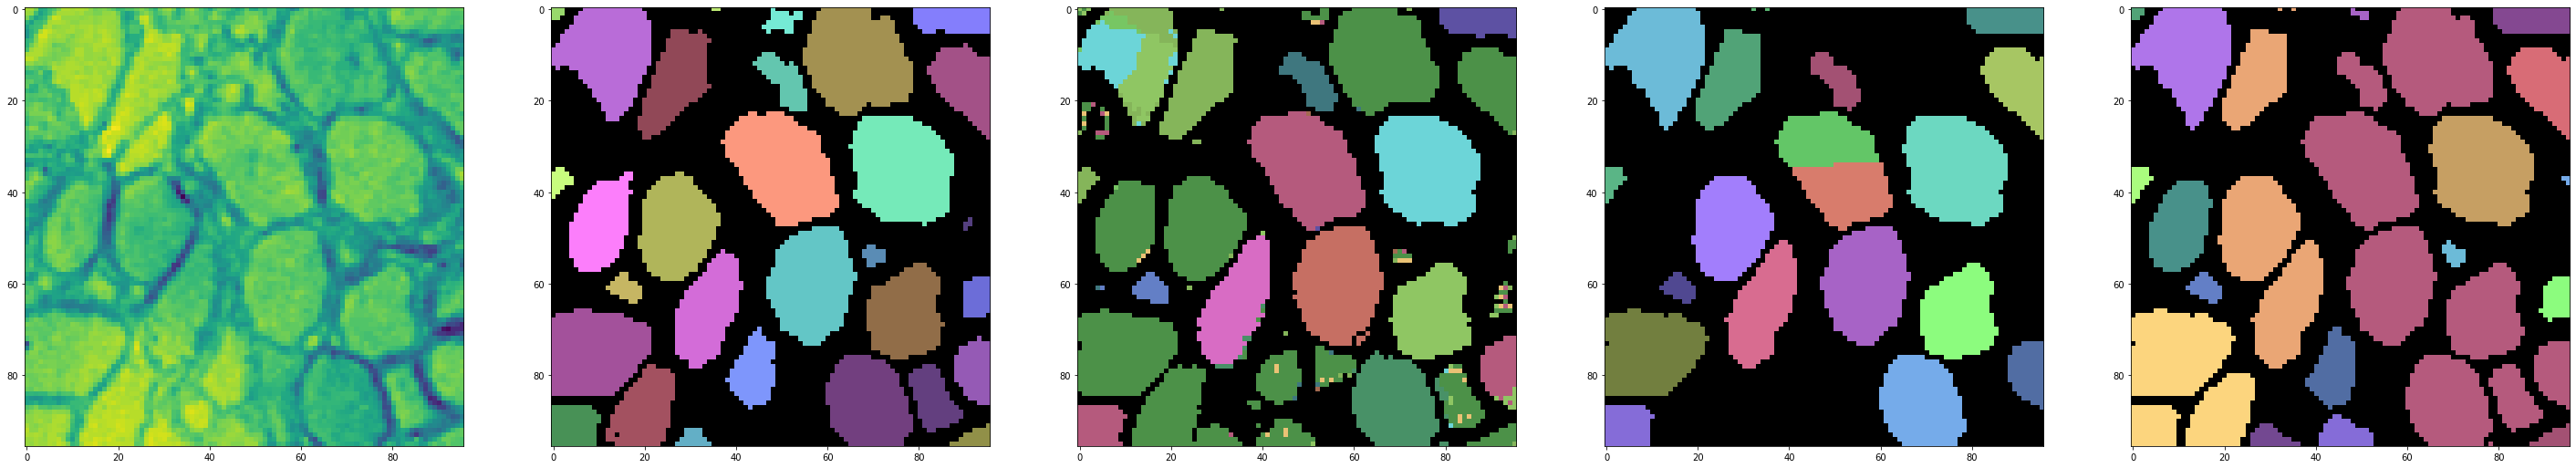

10


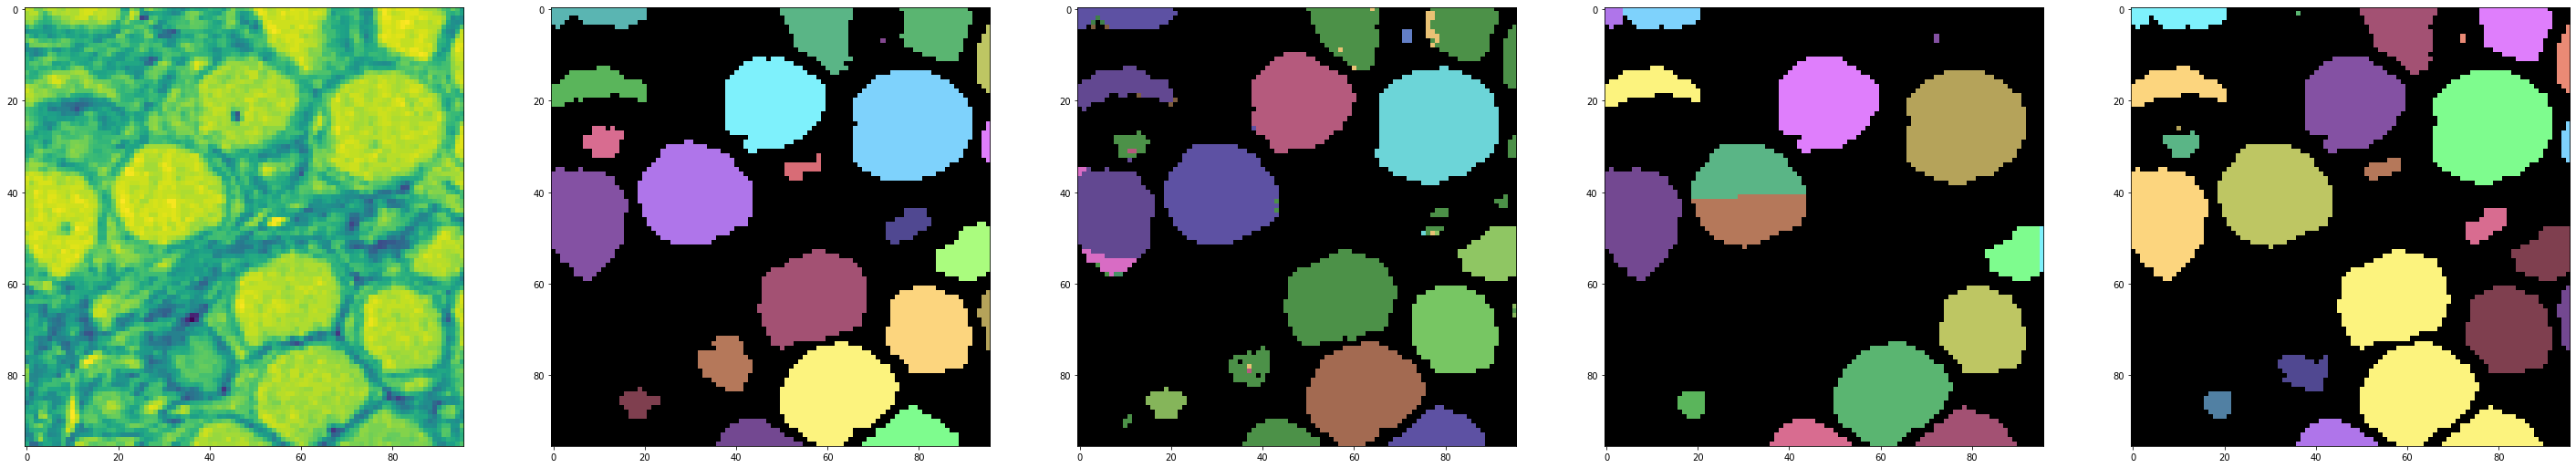

11


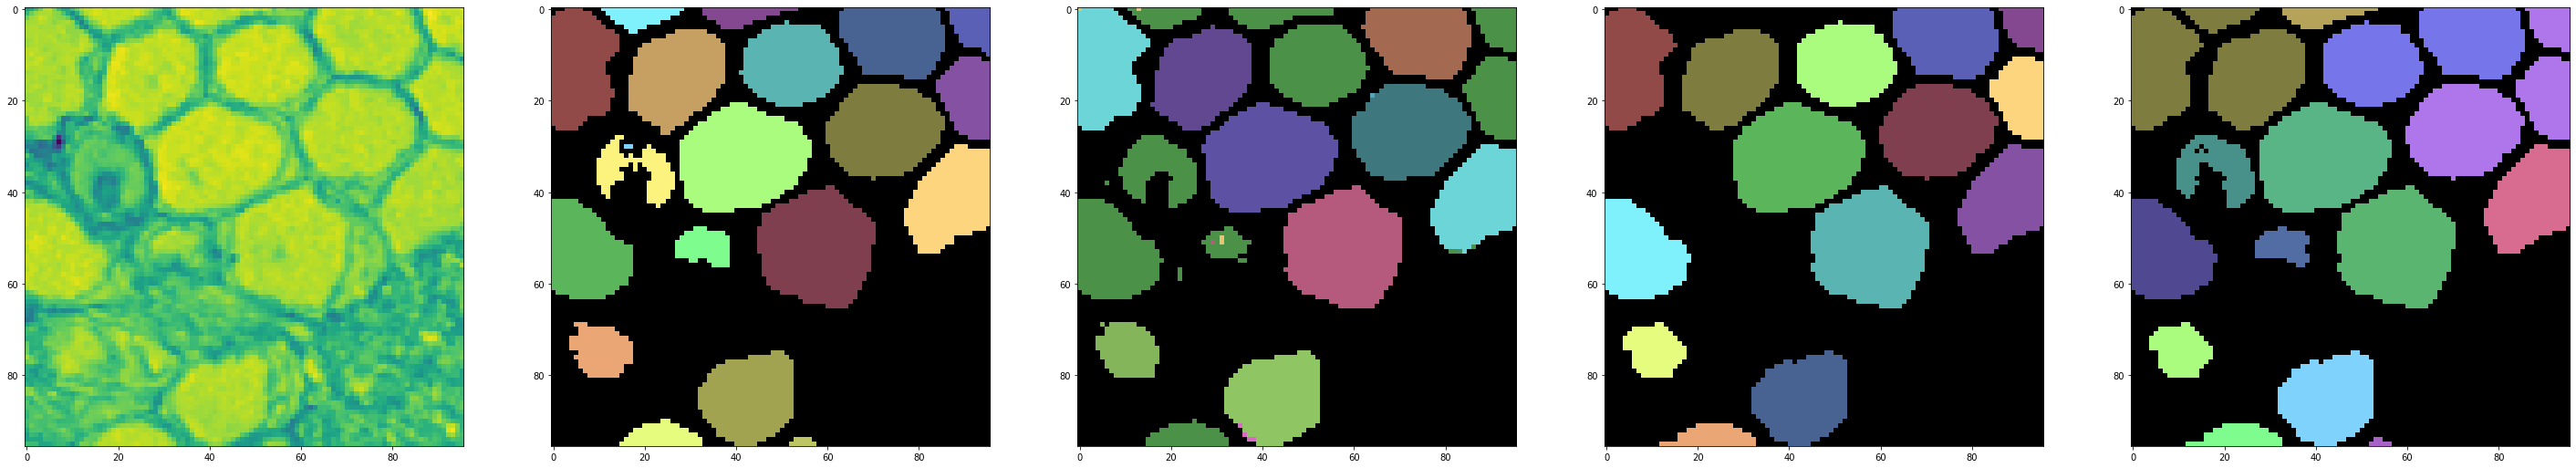

12


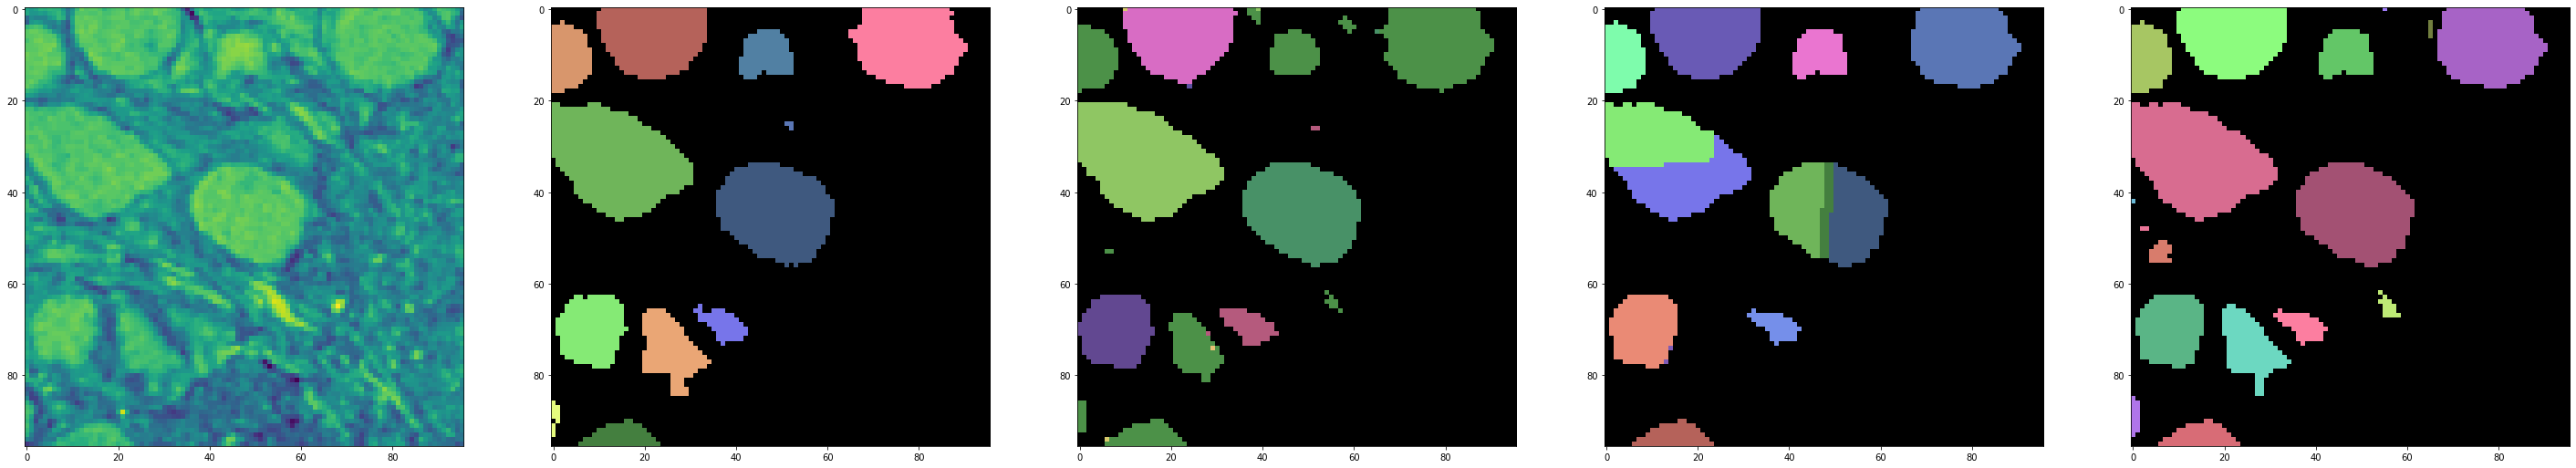

13


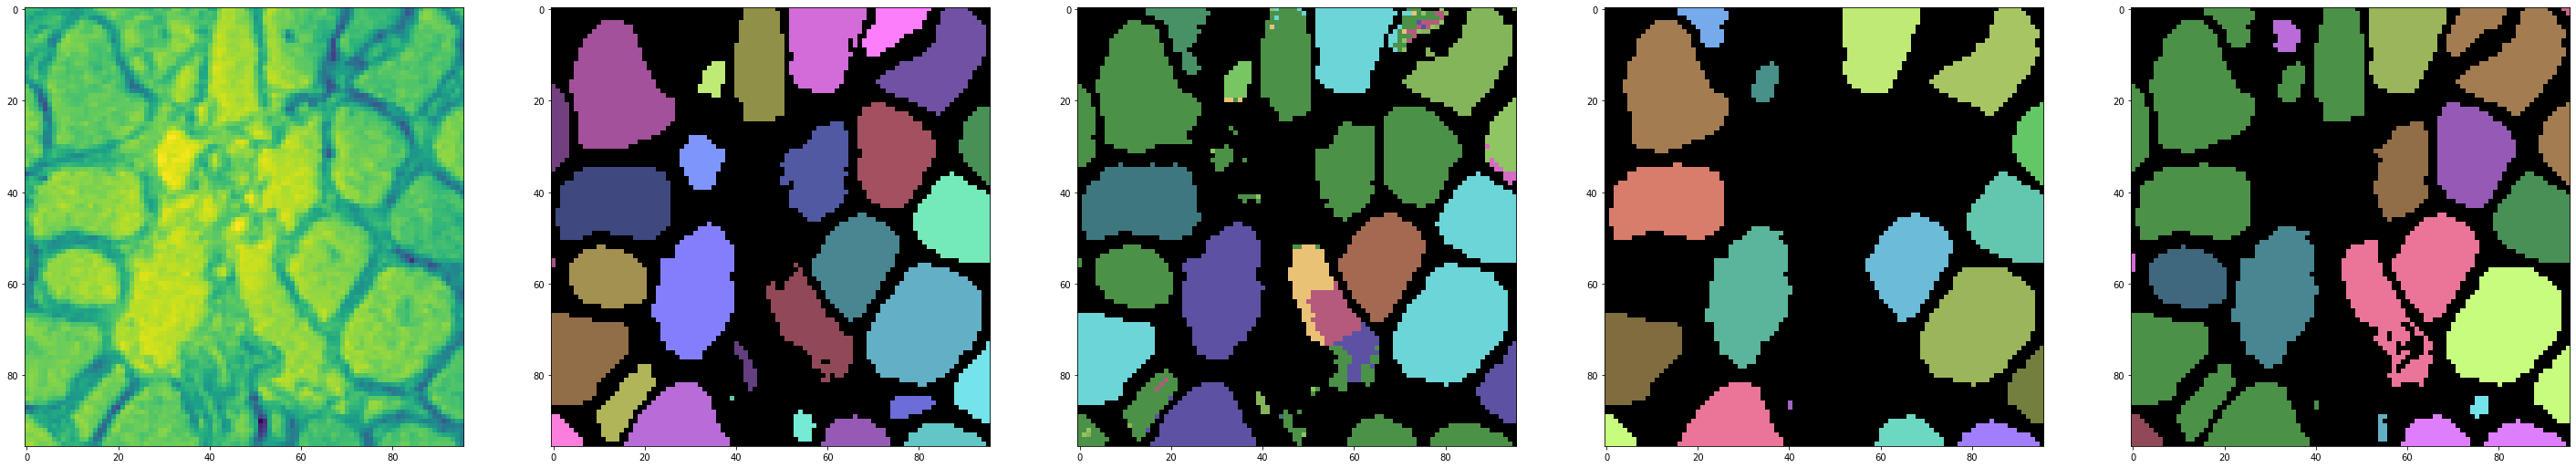

14


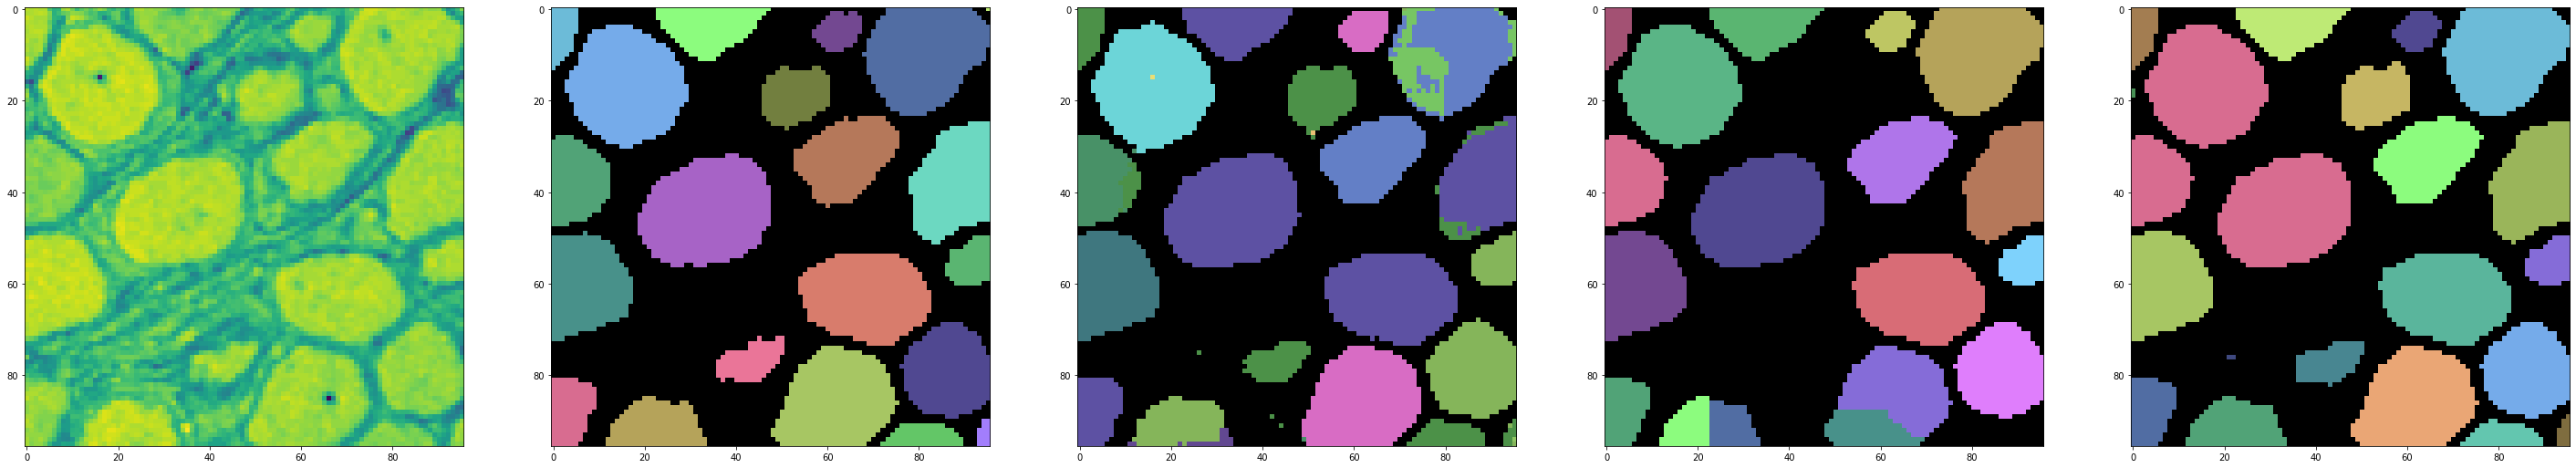

15


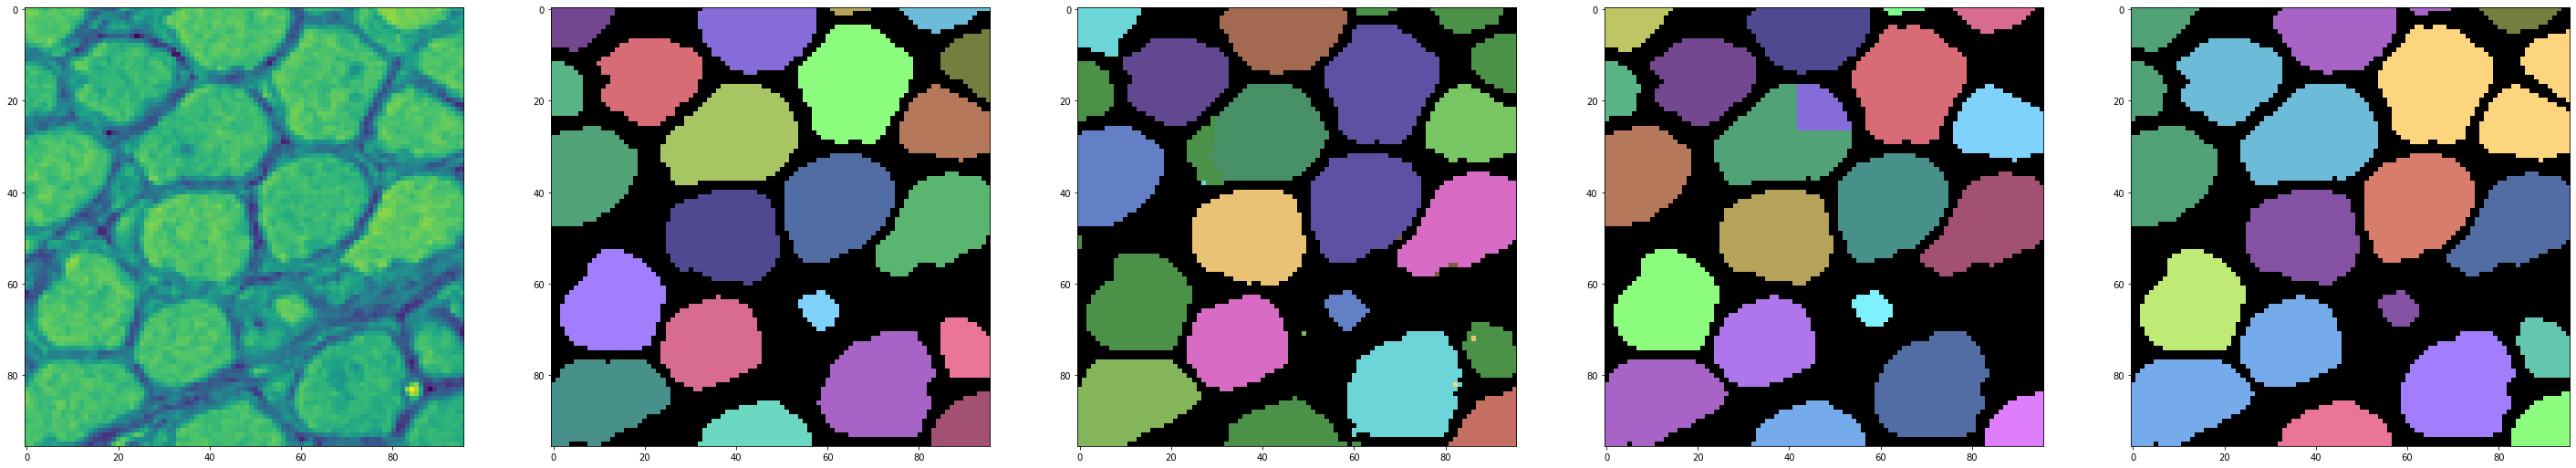

16


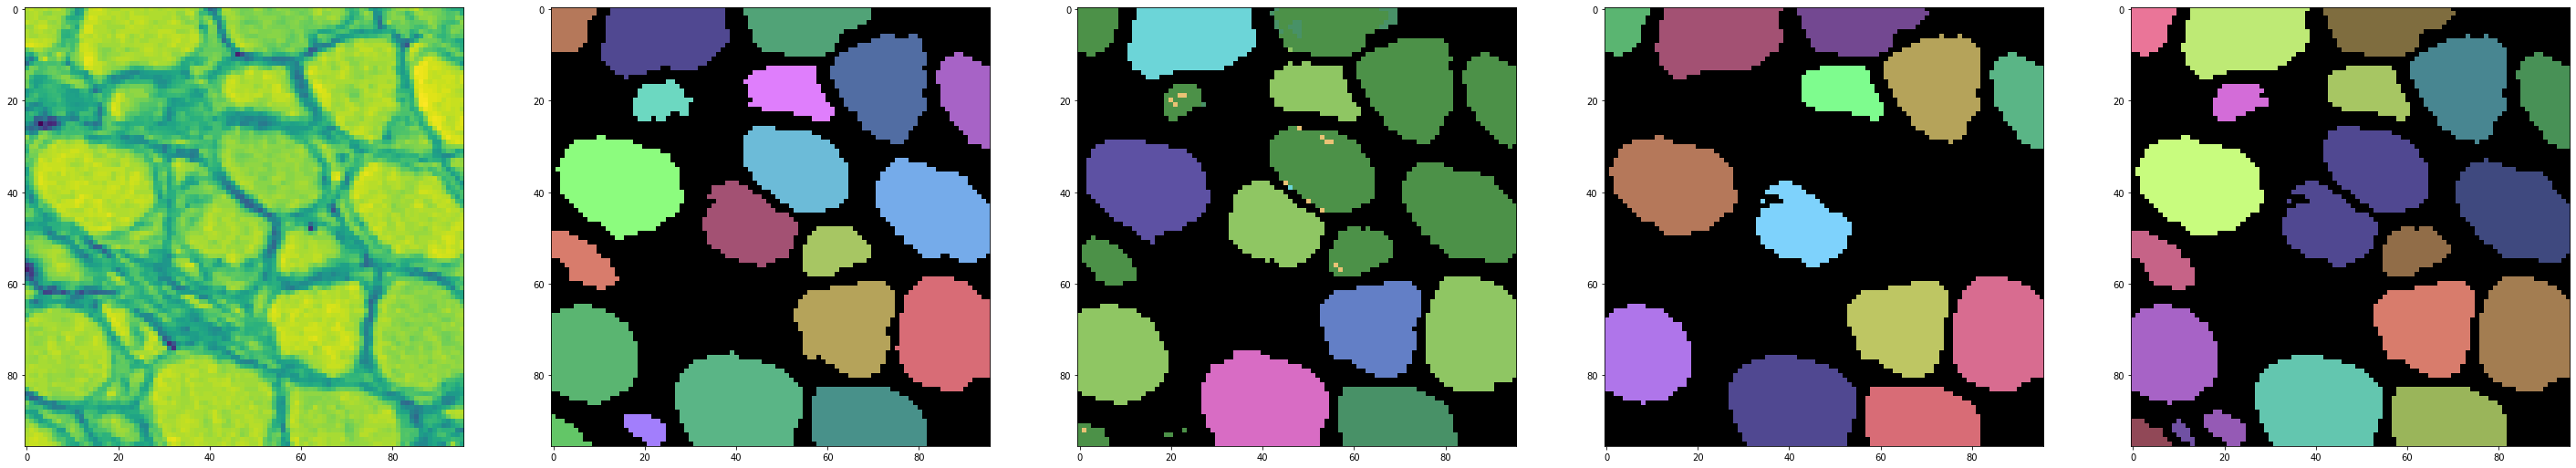

17


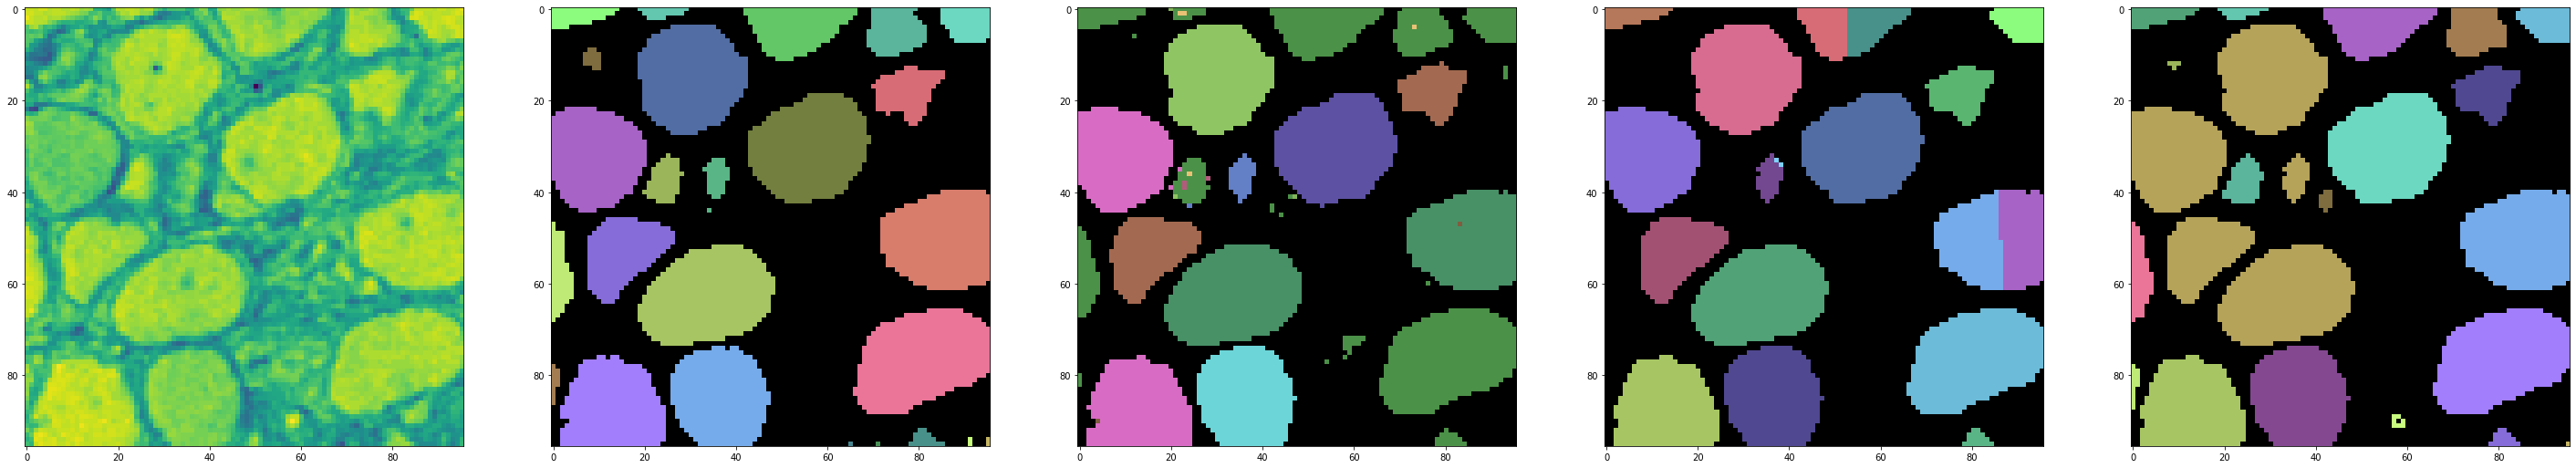

18


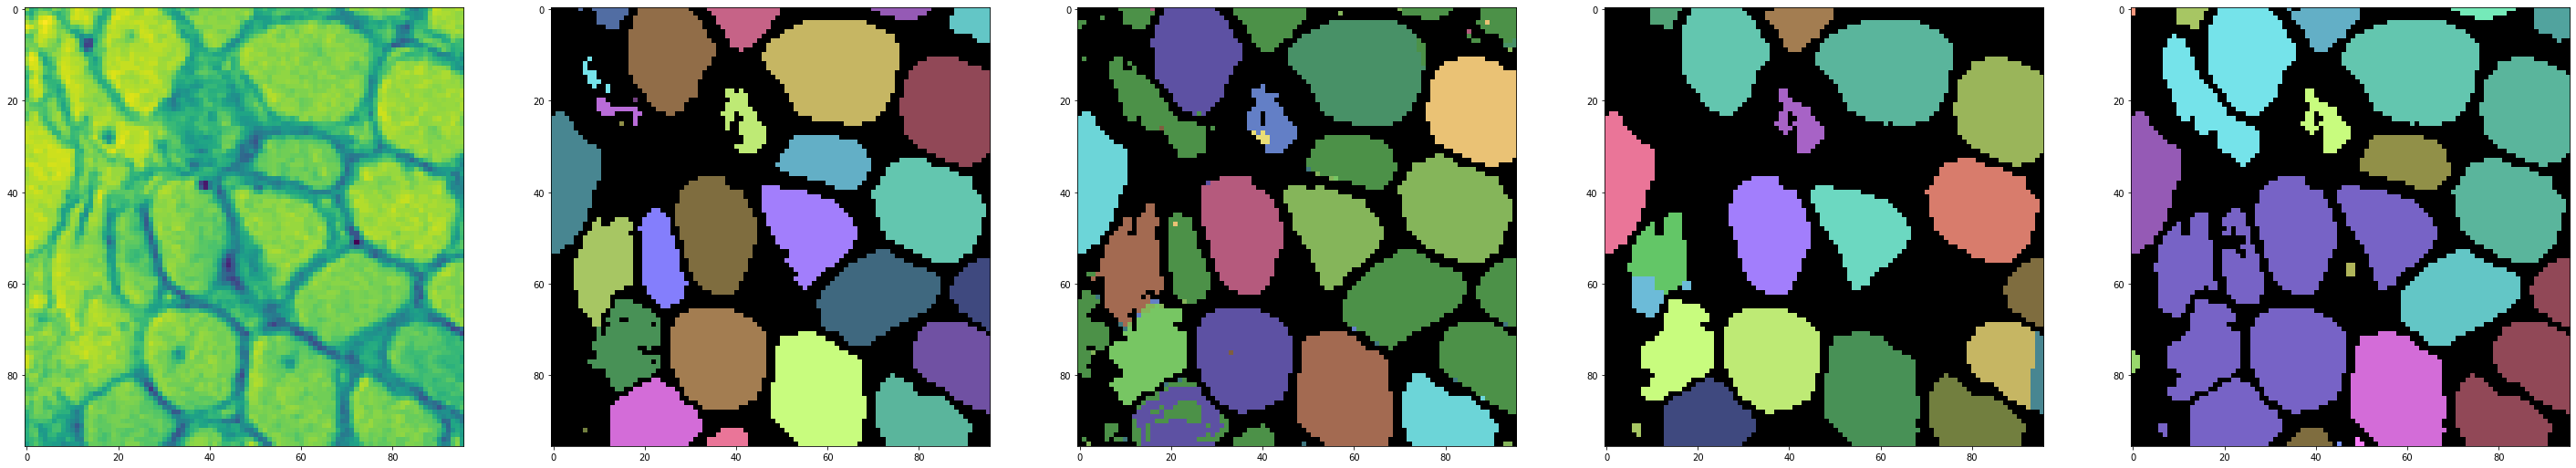

19


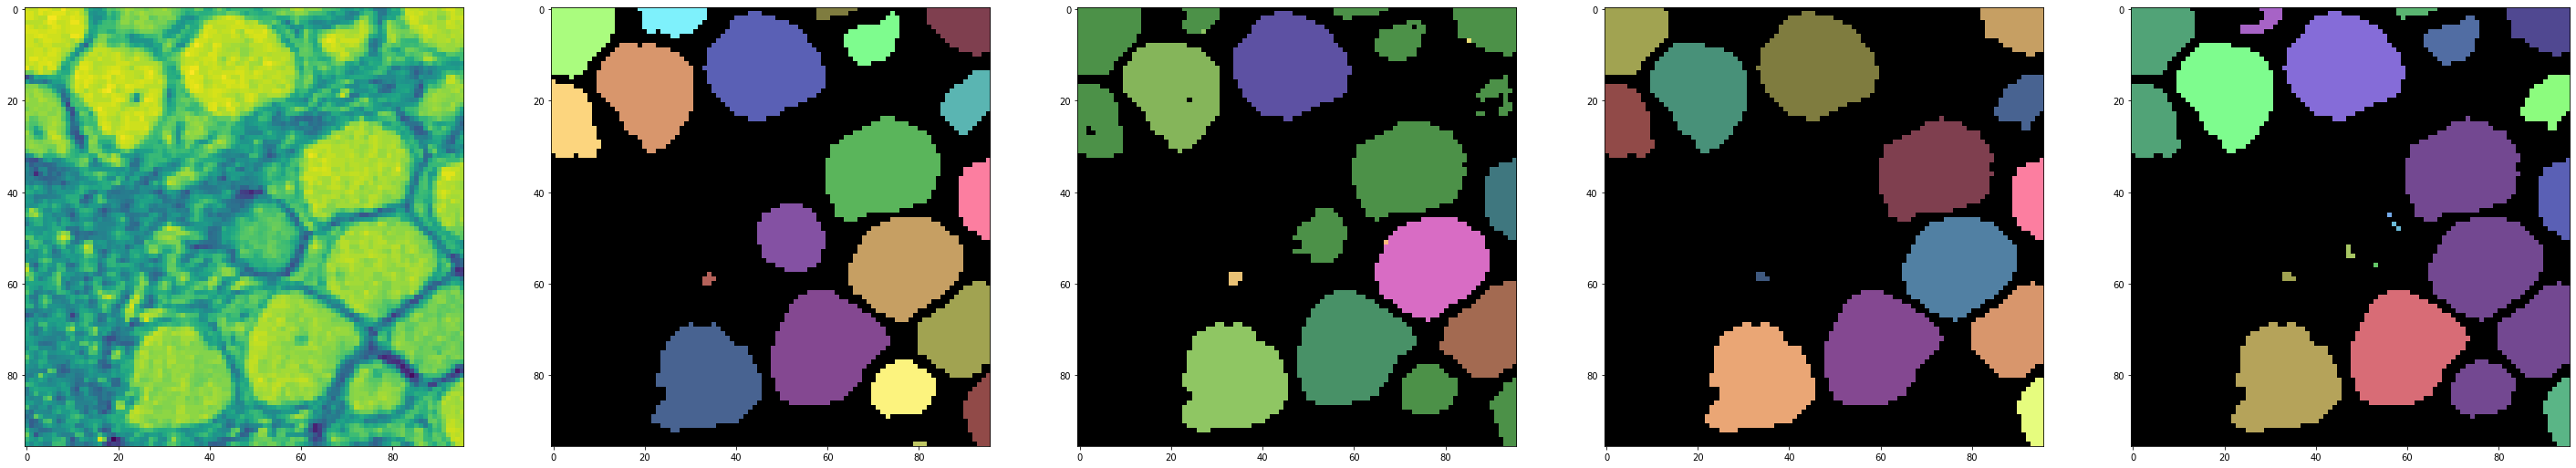

20


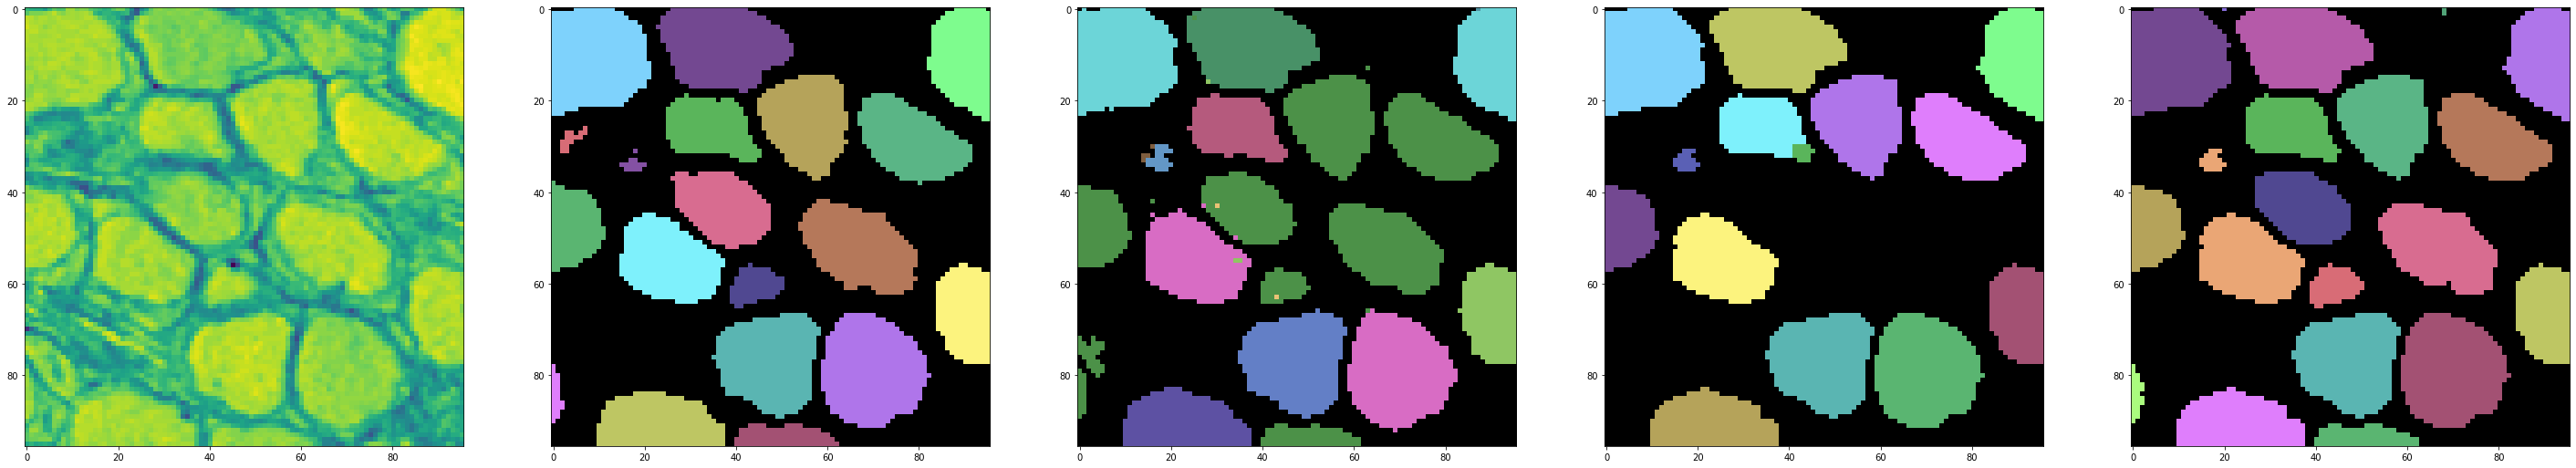

21


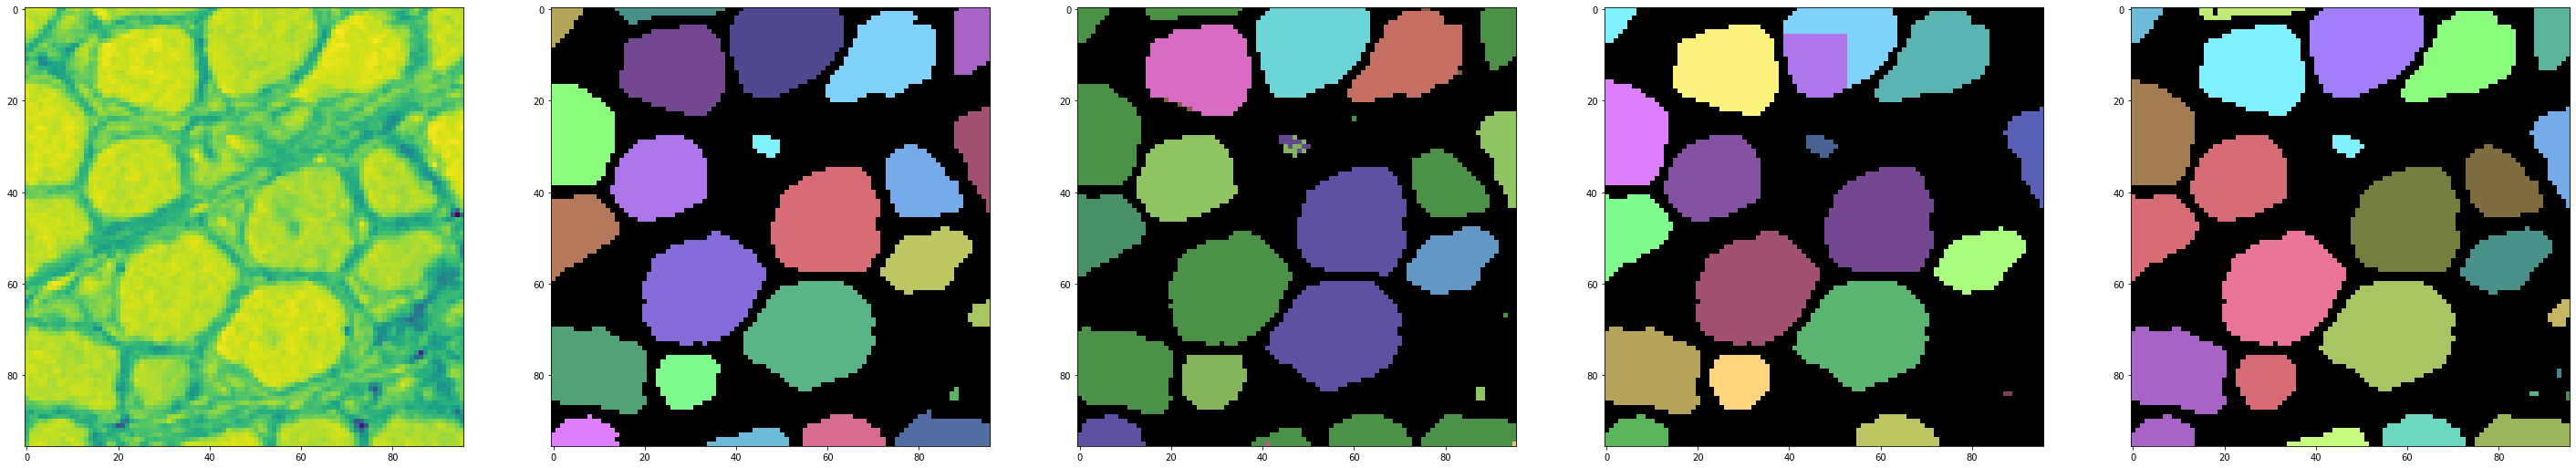

22


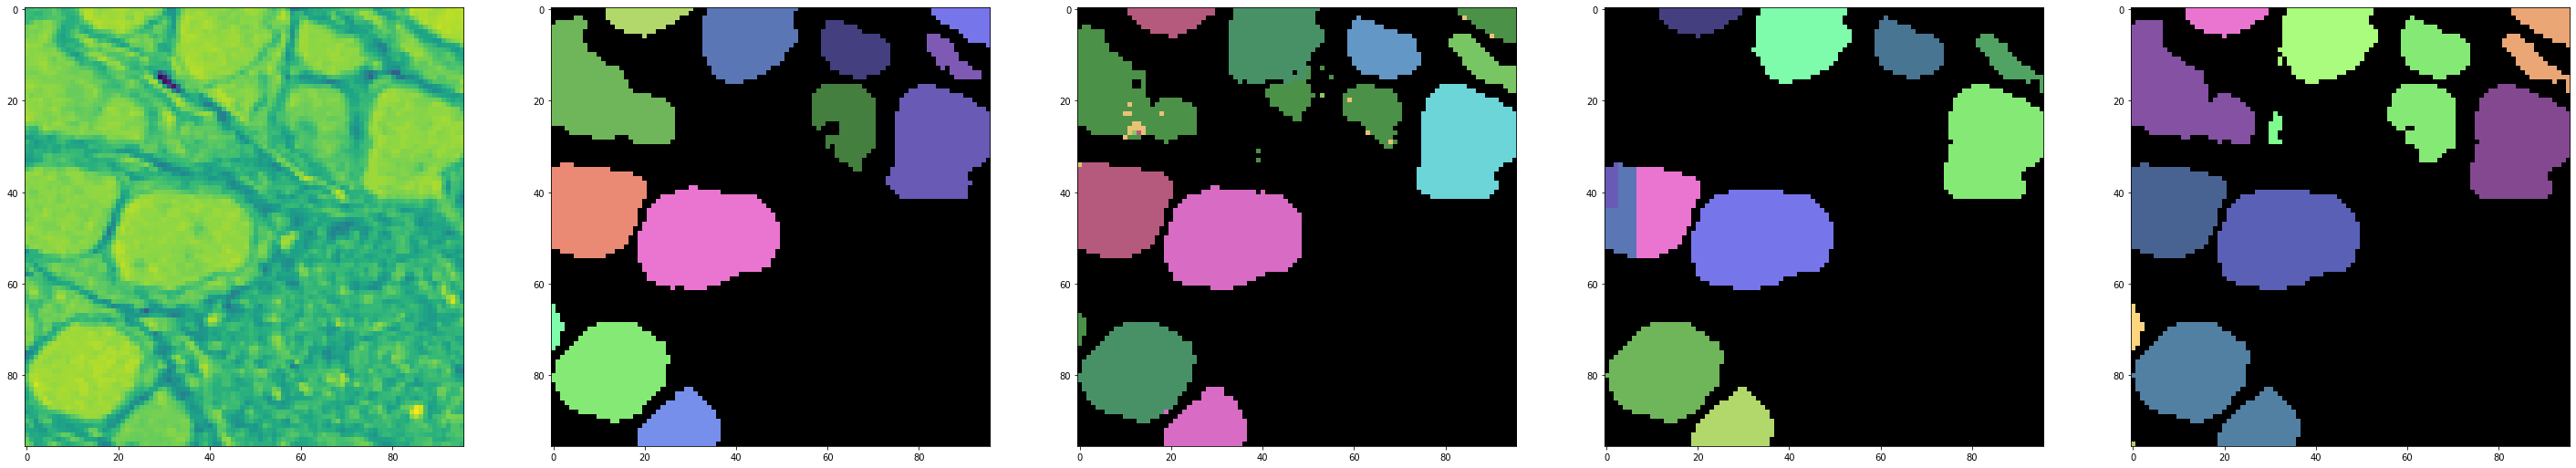

23


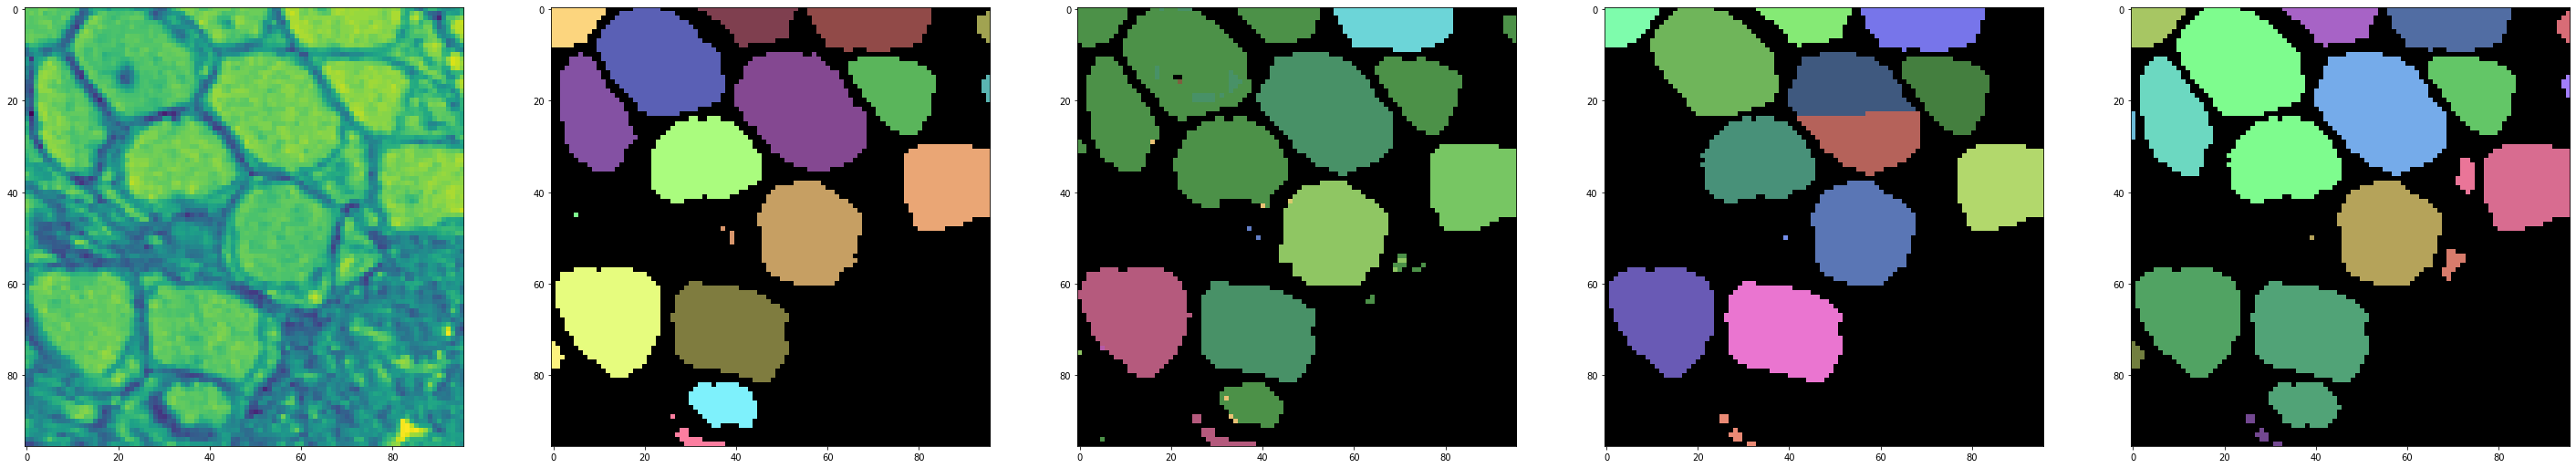

24


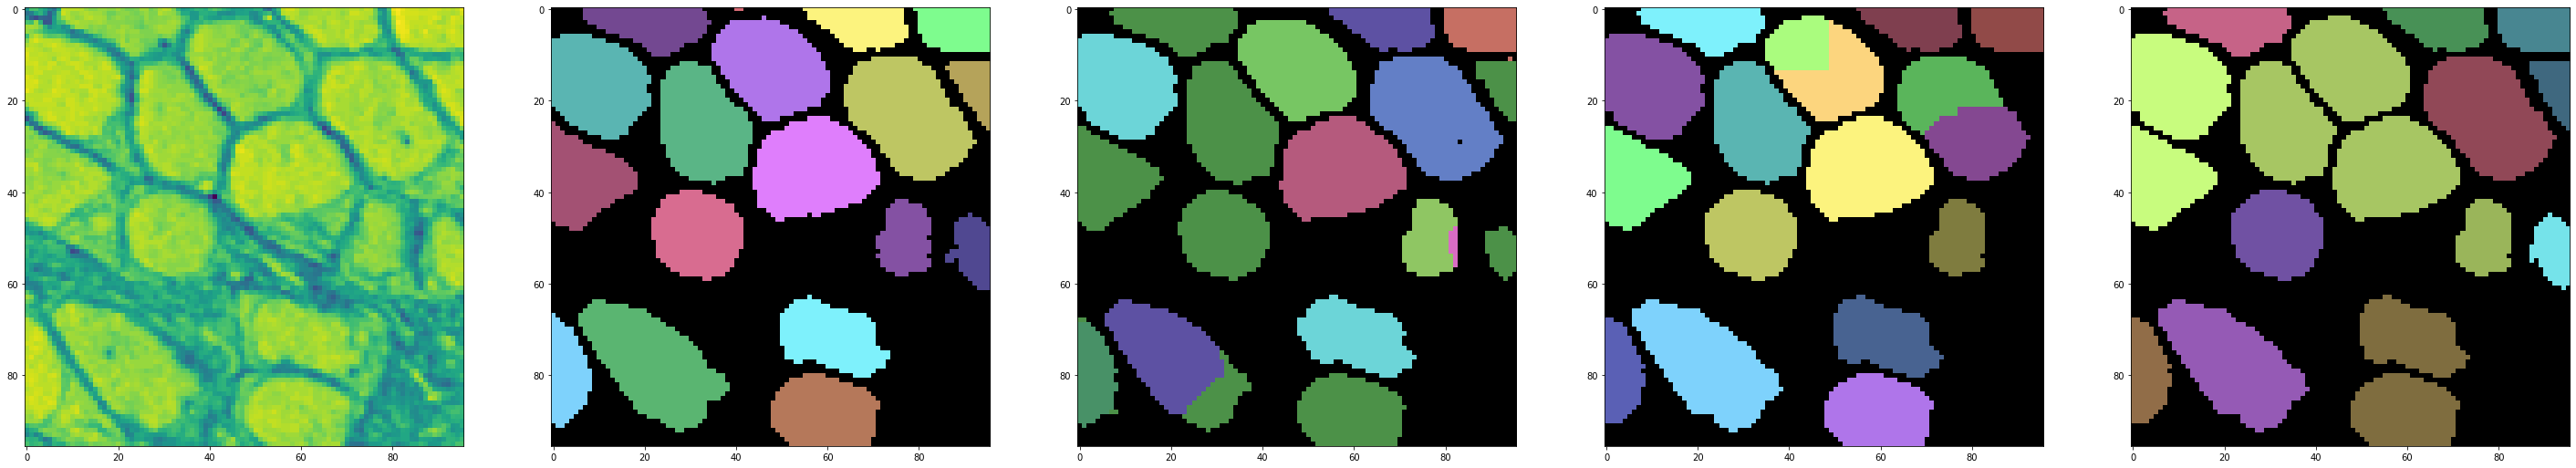

In [30]:
lbl2rgb = color_generator (200)
for idx in range (0, 25):
    print (idx)
    fig, ax = plt.subplots (1,5, figsize=(50,15))
    ax [0].imshow (em [idx] [0])
    ax [1].imshow (lbl2rgb (gt [idx][0]))
    ax [2].imshow (lbl2rgb (graphcl [idx][0]))
    ax [3].imshow (lbl2rgb (unet_wsh [idx][0]))
    ax [4].imshow (lbl2rgb (unet_cncpt [idx][0]))
    plt.show ()

In [54]:
# def show3sides (vol):
#     fig, ax = plt.subplots (1,3, figsize=(30,10))
#     ax [0].imshow (lbl2rgb (vol [0]))
#     ax [1].imshow (lbl2rgb (vol [:,0]))
#     ax [2].imshow (lbl2rgb (vol [:,:,0]))
#     plt.show ()

# def lbl2gray (img):
#     ret = np.repeat (np.expand_dims (img, -1), 3, -1)
#     return ret

# def show3sides_gray (vol):
#     fig, ax = plt.subplots (1,3, figsize=(30,10))
#     ax [0].imshow ( vol [0], cmap='gray')
#     ax [1].imshow ( vol [:,0], cmap='gray')
#     ax [2].imshow ( vol [:,:,0], cmap='gray')
#     plt.show ()

In [68]:
idx = 15

# show3sides_gray (em [idx][3:,3:,3:])
# show3sides (gt [idx][3:,3:,3:])
# show3sides (graphcl [idx][3:,3:,3:])
# show3sides (graphcl [idx][3:,3:,3:] // 2) 
# show3sides (graphcl [idx][3:,3:,3:] // 4) 
# show3sides (graphcl [idx][3:,3:,3:] // 8) 
# show3sides (graphcl [idx][3:,3:,3:] // 16) 


# vis_dir = "3d_zebrafish/vis/"
# vis_vol = lbl2rgb (graphcl [idx])[3:,3:,3:]
# vis_gt  = lbl2rgb (gt [idx])[3:,3:,3:]
# os.makedirs (vis_dir, exist_ok=True)

# io.imsave (vis_dir + "em_xy" + '.png', em [idx][3:,3:,3:][0])
# io.imsave (vis_dir + "em_yz" + '.png', em [idx][3:,3:,3:][:,0])    
# io.imsave (vis_dir + "em_zx" + '.png', em [idx][3:,3:,3:][:,:,0])   

# io.imsave (vis_dir + "gt_xy" + '.png', vis_gt[0])
# io.imsave (vis_dir + "gt_yz" + '.png', vis_gt[:,0])    
# io.imsave (vis_dir + "gt_zx" + '.png', vis_gt[:,:,0])   

# for i in range (5):
#     io.imsave (vis_dir + "xy" + str (i) + '.png', vis_vol[0] // (2**i))
#     io.imsave (vis_dir + "yz" + str (i) + '.png', vis_vol[:,0] // (2**i))
#     io.imsave (vis_dir + "zx" + str (i) + '.png', vis_vol[:,:,0] // (2**i))  

io.imsave (vis_dir + "em.tif", em [idx].astype (np.int32))
io.imsave (vis_dir + "gt.tif", gt [idx].astype (np.int32))

tmp = np.mod (graphcl [idx].astype (np.int32), 2)
tmp2 = np.copy (graphcl [idx].astype (np.int32)) // 2

for i in range (5):
    for j in range (50): 
        tmp [0][0][j] = j
    io.imsave (vis_dir + "graphcl_" + str (i) + '.tif', tmp)
    tmp += np.mod (tmp2, 2) * 2 ** (i + 1)
    tmp2 //= 2

In [26]:
result_dir = "3d_zebrafish"
lbl2rgb = color_generator (200)
res = [graphcl, unet_wsh, unet_cncpt, gt, em]
meds = ["graphcl", "wsh", "cncpt"] + ["gt", "em"]
for med, lbl_lists in zip (meds, res):
    med_dir = result_dir + "/" + med + '/'
    os.makedirs (med_dir, exist_ok=True)
    if med in ['em']:
        continue
    
    for i in range (len_test):
        io.imsave (med_dir + '/' + str (i) + '.tif', lbl2rgb (lbl_lists [i]))

        os.makedirs (result_dir + "/" + 'em' + '/', exist_ok=True)
for i in range (len_test):
    io.imsave (result_dir + '/em/' + str (i) + '.tif', em[i])
         

/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_zebrafish/gt//0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_zebrafish/gt//1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_zebrafish/gt//2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_zebrafish/gt//3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_zebrafish/gt//4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_zebrafish/gt//5.tif is a low contrast image
  warn('%s is a low contrast image' % fname